# Import Library

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [ ]:
from google.colab import files
files.upload()  # pilih file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwinurcahyop","key":"1c520e41dc3c91fb2ea5ac78fc8fa02c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d deayulianisabrina/7-masalah-kulit-indonesia

Dataset URL: https://www.kaggle.com/datasets/deayulianisabrina/7-masalah-kulit-indonesia
License(s): other
 52% 123M/238M [00:00<00:00, 1.29GB/s]
100% 238M/238M [00:00<00:00, 801MB/s] 


In [ ]:
!unzip 7-masalah-kulit-indonesia.zip -d /content/dataset

Archive:  7-masalah-kulit-indonesia.zip
  inflating: /content/dataset/FIX/Jerawat/1.jpg  
  inflating: /content/dataset/FIX/Jerawat/10.jpg  
  inflating: /content/dataset/FIX/Jerawat/100.jpg  
  inflating: /content/dataset/FIX/Jerawat/101.jpg  
  inflating: /content/dataset/FIX/Jerawat/102.jpg  
  inflating: /content/dataset/FIX/Jerawat/103.jpg  
  inflating: /content/dataset/FIX/Jerawat/104.jpg  
  inflating: /content/dataset/FIX/Jerawat/105.jpg  
  inflating: /content/dataset/FIX/Jerawat/106.jpg  
  inflating: /content/dataset/FIX/Jerawat/107.jpg  
  inflating: /content/dataset/FIX/Jerawat/108.jpg  
  inflating: /content/dataset/FIX/Jerawat/109.jpg  
  inflating: /content/dataset/FIX/Jerawat/11.JPG  
  inflating: /content/dataset/FIX/Jerawat/110.jpg  
  inflating: /content/dataset/FIX/Jerawat/111.jpg  
  inflating: /content/dataset/FIX/Jerawat/112.jpg  
  inflating: /content/dataset/FIX/Jerawat/113.jpg  
  inflating: /content/dataset/FIX/Jerawat/114.jpg  
  inflating: /content/datase

In [ ]:
original_dir = '/content/dataset/FIX'
base_dir = '/content/split_data/FIX'

# Data Processing

### Split Data

In [ ]:
split_ratio = {'train': 0.7, 'val': 0.2, 'test': 0.1}

# Buat folder target
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(original_dir):
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Split gambar
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * split_ratio['train'])
    n_val = int(n_total * split_ratio['val'])

    for i, img_name in enumerate(images):
        src = os.path.join(class_path, img_name)
        if i < n_train:
            dst = os.path.join(base_dir, 'train', class_name, img_name)
        elif i < n_train + n_val:
            dst = os.path.join(base_dir, 'val', class_name, img_name)
        else:
            dst = os.path.join(base_dir, 'test', class_name, img_name)
        shutil.copy2(src, dst)


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1708 images belonging to 7 classes.
Found 490 images belonging to 7 classes.
Found 252 images belonging to 7 classes.


# Modeling

In [ ]:
base_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True

# Freeze sebagian awal layer, hanya fine-tune sebagian akhir
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,026,311 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
EPOCHS = 50

history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 520ms/step - accuracy: 0.1781 - loss: 2.0103 - val_accuracy: 0.2531 - val_loss: 1.9352
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 375ms/step - accuracy: 0.3925 - loss: 1.6859 - val_accuracy: 0.3143 - val_loss: 1.7331
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.4903 - loss: 1.4910 - val_accuracy: 0.3755 - val_loss: 1.6299
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.5316 - loss: 1.3439 - val_accuracy: 0.4367 - val_loss: 1.5170
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.5658 - loss: 1.2459 - val_accuracy: 0.4510 - val_loss: 1.4615
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - accuracy: 0.6093 - loss: 1.0950 - val_accuracy: 0.4959 - val_loss: 1.3516
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - accuracy: 0.6921 - loss: 0.9584 - val_accuracy: 0.5224 - val_loss: 1.2701
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - accuracy: 0.6563 - loss: 0

# Evaluation

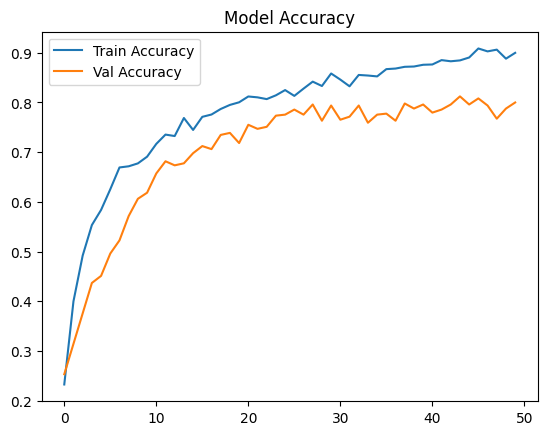

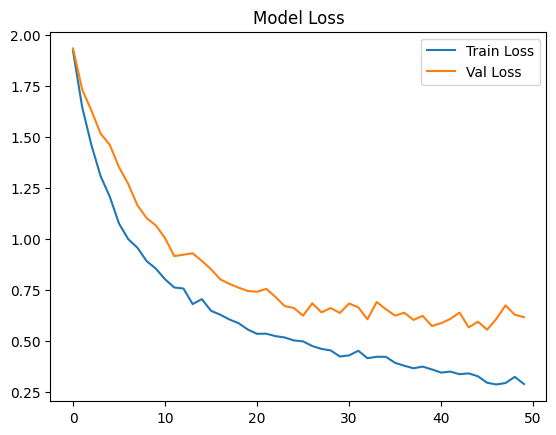

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluasi di test set
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.7801 - loss: 0.6175
Test Accuracy: 79.76%


In [ ]:
# Evaluasi di train set
loss, acc = model.evaluate(train_data)
print(f"Train Accuracy: {acc * 100:.2f}%")

107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - accuracy: 0.9393 - loss: 0.1942
Train Accuracy: 93.97%


In [ ]:
# Evaluasi di val set
loss, acc = model.evaluate(val_data)
print(f"Val Accuracy: {acc * 100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.7708 - loss: 0.7496
Val Accuracy: 80.20%


In [ ]:
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step
                             precision    recall  f1-score     support
Jerawat                       0.864865  0.888889  0.876712   36.000000
Kulit Kering atau Dehidrasi   0.547619  0.638889  0.589744   36.000000
Kulit Kusam atau Noda Hitam   0.676471  0.638889  0.657143   36.000000
Kulit Sensitif atau iritasi   1.000000  0.805556  0.892308   36.000000
Pori-Pori Besar               0.755556  0.944444  0.839506   36.000000
Produksi Minyak Berlebih      0.909091  0.833333  0.869565   36.000000
Tanda-Tanda Penuaan           1.000000  0.888889  0.941176   36.000000
accuracy                      0.805556  0.805556  0.805556    0.805556
macro avg                     0.821943  0.805556  0.809451  252.000000
weighted avg                  0.821943  0.805556  0.809451  252.000000


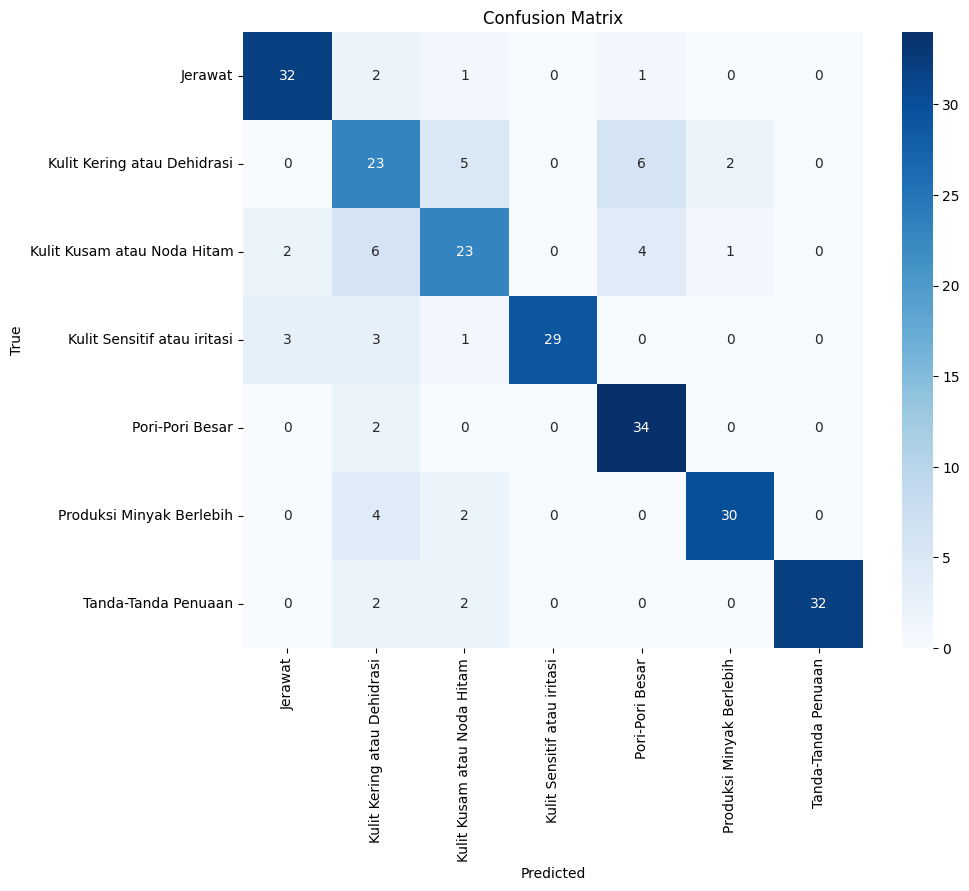

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Uji Coba Model

In [ ]:
model.save("model.h5")


### Mengaplod Gambar

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving p.jpg to p.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


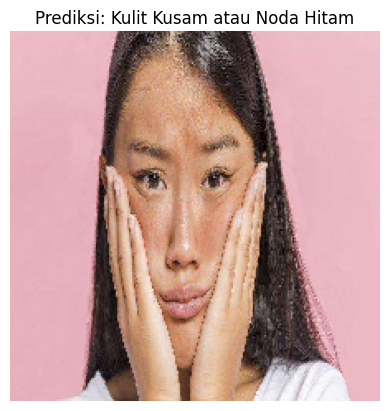

'Kulit Kusam atau Noda Hitam'

In [ ]:
def predict_image(image_path, model, class_indices):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_labels = list(class_indices.keys())
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}")
    plt.axis('off')
    plt.show()
    return predicted_class

# Load model
model = load_model("model.h5")
# Uji satu gambar
predict_image(list(uploaded.keys())[0], model, train_data.class_indices)